# Time Series Forecasting: Daily Atmospheric CO2 at Mauna Loa

References:

https://gml.noaa.gov/ccgg/trends/data.html

https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

,Year,Month,Day,Time,CO2
13937,2020,1,1,2020.0014,412.85
13938,2020,1,3,2020.0068,413.21
13939,2020,1,4,2020.0096,413.44
13940,2020,1,5,2020.0123,413.78
13941,2020,1,6,2020.0150,413.49
...,...,...,...,...,...
15297,2024,3,8,2024.1844,426.10
15298,2024,3,9,2024.1872,425.54
15299,2024,3,10,2024.1899,425.10
15300,2024,3,11,2024.1926,424.95


,Year,Month,Day,Time,CO2,CO2_filtered
13937,2020,1,1,2020.0014,412.85,413.274023
13938,2020,1,3,2020.0068,413.21,413.301520
13939,2020,1,4,2020.0096,413.44,413.323660
13940,2020,1,5,2020.0123,413.78,413.341190
13941,2020,1,6,2020.0150,413.49,413.354856
...,...,...,...,...,...,...
15297,2024,3,8,2024.1844,426.10,425.129389
15298,2024,3,9,2024.1872,425.54,425.152398
15299,2024,3,10,2024.1899,425.10,425.172288
15300,2024,3,11,2024.1926,424.95,425.188832


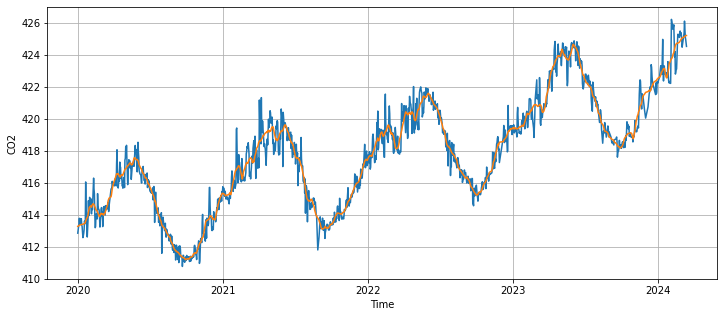

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.signal import savgol_filter
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

df = pd.read_csv("co2_daily_mlo.csv")

# Only get the data from 2020 onwards
df = df[df["Year"] >= 2020]

display(df)
plt.figure(figsize=(12,5))
plt.plot(df["Time"], df["CO2"])

# Apply the Savitzky-Golay filter to smoothen data
yhat = savgol_filter(df["CO2"].to_numpy(), 31, 3)
df["CO2_filtered"] = yhat
plt.plot(df["Time"], yhat)
display(df)
plt.xlabel("Time")
plt.ylabel("CO2")
plt.grid()
plt.show()

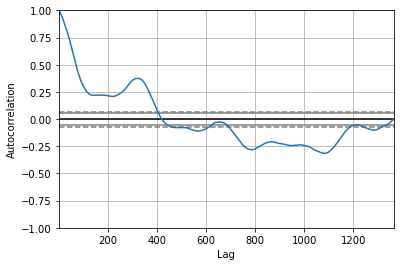

In [2]:
autocorrelation_plot(df["CO2_filtered"])
plt.show()

## Fit an ARIMA model for 2020 data onwards

D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1092
Model:                ARIMA(10, 3, 0)   Log Likelihood                4363.682
Date:                Fri, 15 Mar 2024   AIC                          -8705.365
Time:                        01:07:31   BIC                          -8650.441
Sample:                             0   HQIC                         -8684.577
                               - 1092                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0944      0.023    -46.917      0.000      -1.140      -1.049
ar.L2         -1.0846      0.038    -28.815      0.000      -1.158      -1.011
ar.L3         -1.0452      0.045    -23.284      0.0

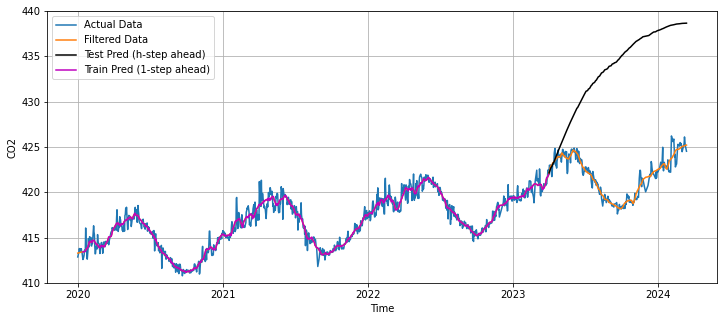

In [3]:
# ARIMA(p,D,q) --> p output lags, D levels of differencing, q moving average lags

# Split data into 80% Training, 20% Testing
N = len(df)
train_N = int(np.round(N*0.8))

X_train = df.iloc[:train_N,3]
X_test = df.iloc[train_N:,3]
y_train_ = yhat[:train_N].reshape(-1,1)
y_test_ = yhat[train_N:].reshape(-1,1)

scaler = MinMaxScaler()
y_train = scaler.fit_transform(y_train_)
y_test = scaler.transform(y_test_)

p, D, q = 10, 3, 0
mdl = ARIMA(y_train, order=(p, D, q))
model_fit = mdl.fit()

print(model_fit.summary())

y_test_pred = model_fit.forecast(N-train_N).reshape(-1,1)
y_train_pred = np.zeros((len(X_train)-p-1, 1))

for i in range(p+1, train_N):
    y_train_pred[i-p-1] = model_fit.predict(i, i)

y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)
    
plt.figure(figsize=(12,5))
plt.plot(df["Time"], df["CO2"],
         label='Actual Data')
plt.plot(df["Time"], df["CO2_filtered"], 
         label='Filtered Data')
plt.plot(X_test, y_test_pred,color='k', 
         label='Test Pred (h-step ahead)')
plt.plot(X_train[p+1:], y_train_pred,color='m', 
         label='Train Pred (1-step ahead)')
plt.xlabel("Time")
plt.ylabel("CO2")
plt.ylim((410, 440))
plt.legend()
plt.grid()
plt.show()

## Train an LSTM for 2020 data onwards

In [4]:
def create_dataset(dataset, look_back=1):
    X,Y = [], []
    for i in range(len(dataset)-look_back-1):
        X.append(dataset[i:(i+look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 5
trainX, trainY = create_dataset(y_train, look_back)
testX, testY = create_dataset(y_test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

(1086, 1, 5)
(267, 1, 5)
(1086,)
(267,)


In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(LSTM(8, input_shape=(1, look_back)))
model.add(Dense(8))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8)                 448       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 529
Trainable params: 529
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
1086/1086 [==============================] - 1s 1ms/step - loss: 0.0142
Epoch 2/100
1086/1086 [==============================] - 2s 2ms/step - loss: 3.1180e-04
Epoch 3/100
1086/1086 [==============================] - 2s 2ms/step - loss: 2.7594e-04
Epoch 4/100
1086/1086 [==============================] - 2s 2ms/step - loss: 2.6953e-04
Epoch 5/100
1086/1086 [==============================] - 2s 2ms/step - loss: 2.2153e-04
Epoch 6/100
1086/1086 [==============================] - 2s 2ms/step - loss: 1.8544e-04
Epoch 7/100
1086/1086 [==============================] - 2s 2ms/step - loss: 1.4932e-04
Epoch 8/100
1086/1086 [==============================] - 1s 775us/step - loss: 1.3194e-04
Epoch 9/100
1086/1086 [==============================] - 1s 713us/step - loss: 1.2733e-04
Epoch 10/100
1086/1086 [==============================] - 1s 725us/step - loss: 1.0947e-04
Epoch 11/100
1086/1086 [==============================] - 1s 838us/step - loss: 1.0621e-04
Epoch 12/100
1086/1086 [==

1086/1086 [==============================] - 1s 783us/step - loss: 5.4490e-05
Epoch 91/100
1086/1086 [==============================] - 1s 777us/step - loss: 5.5717e-05
Epoch 92/100
1086/1086 [==============================] - 1s 868us/step - loss: 5.6457e-05 0s - loss: 5.6900e
Epoch 93/100
1086/1086 [==============================] - 1s 948us/step - loss: 5.7756e-05
Epoch 94/100
1086/1086 [==============================] - 1s 827us/step - loss: 5.3143e-05
Epoch 95/100
1086/1086 [==============================] - 1s 846us/step - loss: 5.4668e-05
Epoch 96/100
1086/1086 [==============================] - 1s 834us/step - loss: 5.8559e-05
Epoch 97/100
1086/1086 [==============================] - 1s 892us/step - loss: 5.7251e-05
Epoch 98/100
1086/1086 [==============================] - 1s 880us/step - loss: 6.1111e-05
Epoch 99/100
1086/1086 [==============================] - 1s 837us/step - loss: 5.7893e-05
Epoch 100/100
1086/1086 [==============================] - 1s 833us/step - loss: 5.6

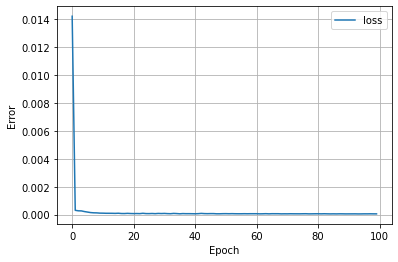

In [6]:
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))
history = model.fit(trainX, trainY, epochs=100, batch_size=1)
plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid()

In [7]:
# make predictions
trainY, testY = trainY.reshape(-1,1), testY.reshape(-1,1)
trainPredict = model.predict(trainX).reshape(-1,1)
testPredict = model.predict(testX).reshape(-1,1)

# revert to original scale
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)
trainY = scaler.inverse_transform(trainY)
testY = scaler.inverse_transform(testY)

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.07 RMSE
Test Score: 0.26 RMSE


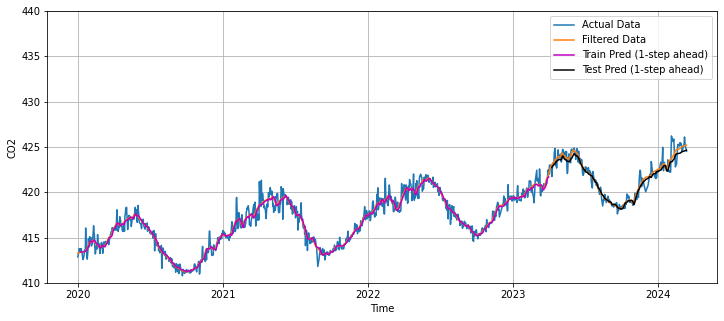

In [8]:
plt.figure(figsize=(12,5))
plt.plot(df["Time"], df["CO2"],
         label='Actual Data')
plt.plot(df["Time"], df["CO2_filtered"], 
         label='Filtered Data')

plt.plot(X_train[look_back+1:], trainPredict, color='m', 
         label='Train Pred (1-step ahead)')
plt.plot(X_test[look_back+1:], testPredict, color='k', 
         label='Test Pred (1-step ahead)')

plt.xlabel("Time")
plt.ylabel("CO2")
plt.ylim((410, 440))
plt.legend()
plt.grid()
plt.show()